# Module 5 - Deep neural networks and feature extraction
Neural networks (NN) belong to an entirely different family of learning algorithms called representation learning. Such classifiers learn what they think is most salient about a class directly from the data. Until recently computers were not powerful enough to operate directly on dense data such as images. Instead, researchers used NNs with hand-engineered features as *de facto* feature selectors. 

The past ten years have seen a confluence of advances in computer processing and labeled datasets. Together, these have led to renewed interest and rapid development in NN algorithms. The underlying mechanism remains similar: feed the network labeled examples, see how it does, adjust paramters, and repeat. This process is done many millions of times to tune weights in a network.

There are many specific architectures of neural networks. For most of this tutorial we will focus on using *deep residual networks* or ResNets. ResNets are a refinement of general Convolutional Neural Networks(CNNs) that allow for more efficent training. In essence, there are two distinct phases of a ResNet: feature extraction and classification. The earliest layers of a network are filters that are used to find local regions fitting some pattern in the image.

It turns out, these early fitlers are quite general. That is, they do not change very much regardless of the dataset used for training. We can exploit that fact to use a pre-trained network as a feature extractor. So rather then spending lots of time engineering our our features, we will use a ResNet to pull out the information for us.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.autograd import Variable
import urllib
from PIL import Image
import matplotlib.pyplot as plt
import os
import sys
import copy
import glob
from tqdm import tnrange, tqdm_notebook
from utilities.internet_utils import get_json_url 
from utilities.custom_torch_utils import ImageFolderWithPaths

DATASET_PATH = "/media/storage/image_data/SPC_data/manual_labels/"

We have imported a lot of new stuff here. Most of it is related to pytorch, the library we will be using for running the ResNet.

## Loading a model and preprocessing data

Pytorch ships comes with many preloaded models. Here we will call up ResNet18 and use it with predefinied weights.

In [2]:
# load a pretrained network
resnet18 = models.resnet18(pretrained=True)

This version of resnet has 18 layers and has been already trained with ImageNet. [ImageNet](http://www.image-net.org/) is a huge labeled image dataset maintained by the Stanford Vision Lab. Each image is associated with a noun describing what is in the picture. Each noun has thousands of labeled images assocaited with it. ImageNet is ubiquitious in computer vision research and is used to train many standard models. 

When ResNet18 is trained with ImageNet, it is tuned for *generic object classification* -- sorting cats from dogs, trucks from cars, etc. This particular version was trained with 1000 generic object classes.

Now let us take our diatom chain image and put it through the net and see what we get.

image size: (1736, 928)


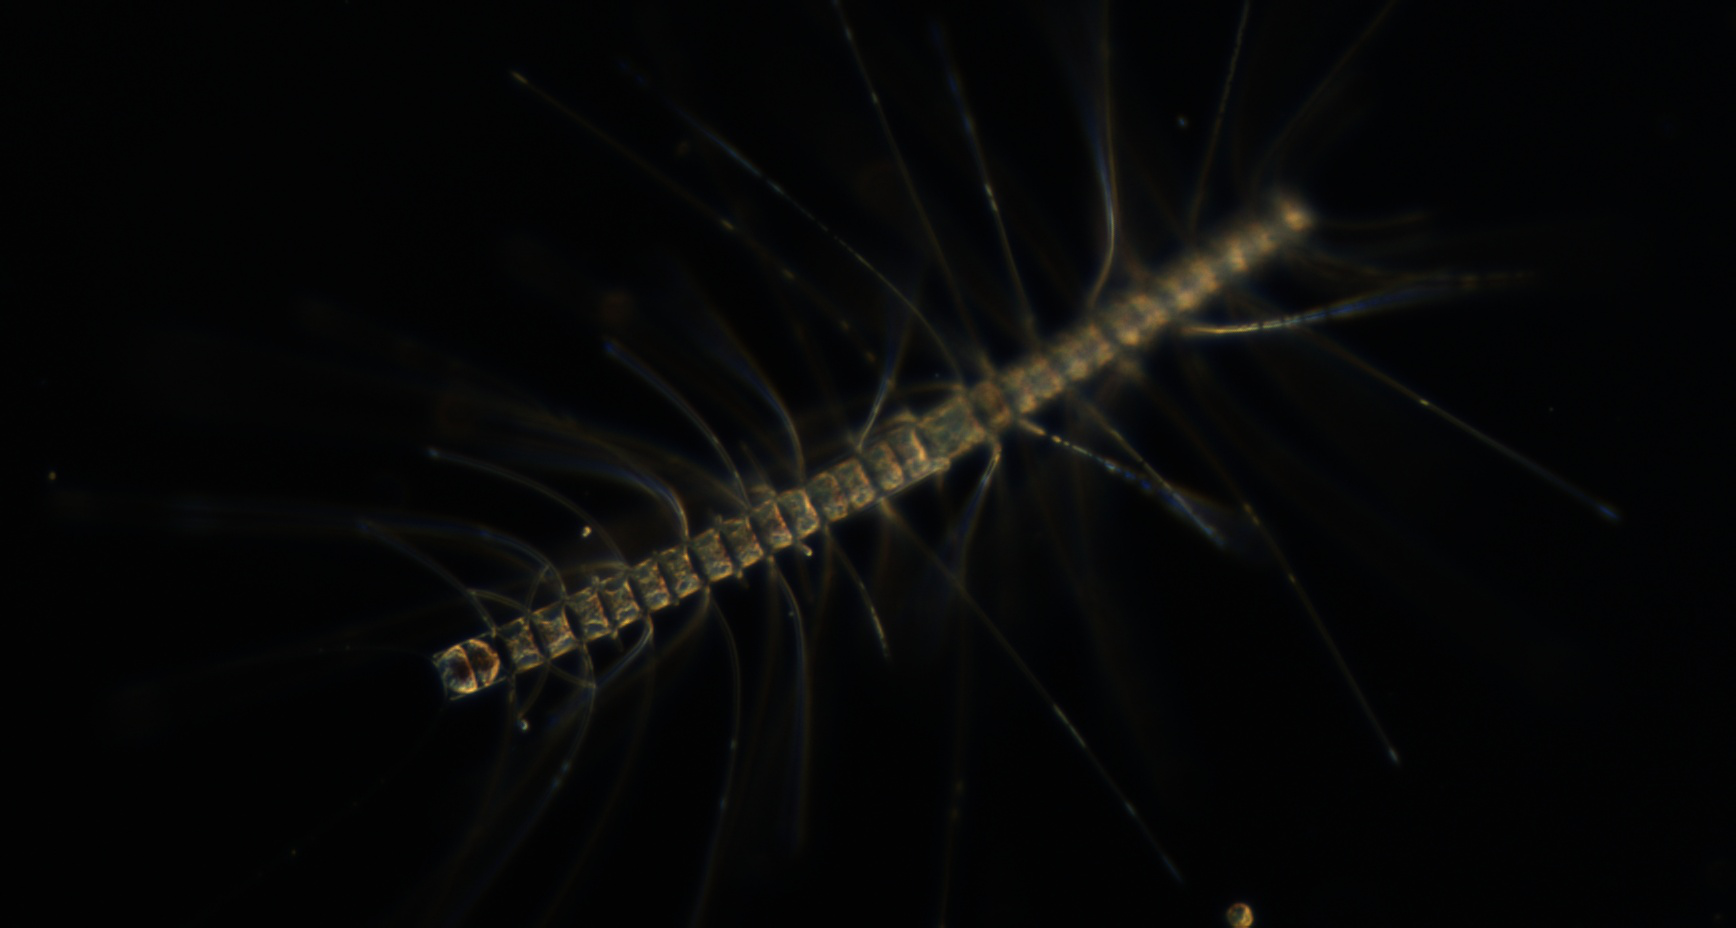

In [3]:
# load the image
ptf = glob.glob(os.path.join(os.getcwd(), 'SPC*'))

# we will load images with Python Image Library (PIL). 
img = Image.open(ptf[0])

# print the image dimensions
print("image size:", img.size)

img

Note that the colors look different. PIL loads the color channels in the familiar RGB order, not the BGR order of OpenCV.

Also notice that the image dimensions are not square. For margin and ensemble classifiers, this is not an issue. But NN require that everything be the same size as it is put into the system. This is a consequence of the underlying math that governs these systems: for the filters to work, they must be applied to data of the same dimension.

To handle this, Pytorch includes an image transform class to put together the *tensors* needed to run through the network. A tensor is a multidimensional matrix with the pre-defined dimensions needed to optimize the speed of training and exectution of a NN. 

ResNet18 expects input tensors to have the shape [batch_dimension, channel, height, width]. 

* *batch_dimension* is the number of images to be processed at once. This size is usually a multiple of 2. The maximum size is limited by the available hardware.
* *channel* is the number of color channels, usually 3. If using gray scale images with a pretrained network, each image must be replicated into 3 channels. 
* *height* and *width* are the image width and height. This dimension is also standardized according to the network architecture. It is also usually a multiple of 2. Images that are not of this shape need to be resized accordingly.

For now, we need to load a tensor of a single image with the dimensions [1, 3, 224, 224].

In [4]:
# define the preprocessing transform
# this first part normalizes the color channels for ImageNet. If this is not done,
# the classifier will get confused.
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

# this is where the image is reshaped into the appropriate tensor dimensions
preprocess = transforms.Compose([
   transforms.Resize((224, 224)),
   transforms.ToTensor(),
   normalize
])

Now that the preprocessing is defined, we can make our image fit into the classifier.

In [ ]:
img_tensor = preprocess(img)

# print out the size
img_tensor.size()

torch.Size([3, 224, 224])

The image is now a torch tensor. But it is not quite ready to go into the network. It is still missing the batch size dimension. Since only this one images is going through, use *unsqueeze*, a Pytorch method, to add a dummy dimension.

In [ ]:
# add the dummy dimension at position 0
# note that unsqueeze works in place. we do not need to copy the matrix
img_tensor.unsqueeze_(0)

img_tensor.size()

torch.Size([1, 3, 224, 224])

Now the tensor has the right size to put through the network.

## Run an image through ResNet

Putting an image or set of image through a trained network is known as a *forward pass*. Since the network is already trained, we are not concerned with tuning the network via *back propagation*. We will get there later. 

For now, the image can be passed through the network and we can see what the label is. 

In [ ]:
# The tensor is converted to a Variable
img_var = Variable(img_tensor)

# pass it through the ResNet18 and record the output
out = resnet18(img_var)

# print out the size of the resulting tensor
out.size()

torch.Size([1, 1000])

The resulting tensor has 1000 entries, one for each class the ResNet was trained with. This output corresponds to the probability of the image belonging to each of the classes. To print a few of them, check out the data array of the tensor.

In [ ]:
# print out a few of the outputs from the last fully connected layer.
out.data.numpy()[0][0:10]

array([-0.62983245, -0.50583845, -0.63889843, -1.60391498, -0.74595118,
       -0.20645984, -0.59663177,  0.36814108,  0.22121386, -0.91924638], dtype=float32)

The final class is just the maximum value of the array. But taking the max will just give us the position. We need the ImageNet key of classes. Here we grab the ImageNet class index as a json document. 

In [ ]:
# unpack json from the following url
label_url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"

# read the dictionary
label_dict = get_json_url(label_url)

# make a list of the first few labels and print them
first_labs = [(item, label_dict[item][1]) for item in list(label_dict.keys())[0:10]]
first_labs

[('0', 'tench'),
 ('1', 'goldfish'),
 ('2', 'great_white_shark'),
 ('3', 'tiger_shark'),
 ('4', 'hammerhead'),
 ('5', 'electric_ray'),
 ('6', 'stingray'),
 ('7', 'cock'),
 ('8', 'hen'),
 ('9', 'ostrich')]

These are the first 10 labels in the ImageNet data set. Those look pretty familiar! Now let's see what ResNet called the diatom chain.

In [ ]:
# get the label
print("ResNet18 sez: ", label_dict[str(out.data.numpy().argmax())][1])

ResNet18 sez:  bucket


So our great and powerful NN thinks this diatom chain is a bucket. 

The point here is that the network is not tuned to think about plankton data. In the next module, we will retrain the network to understand plankton data. 

### A warning about image dimensions

Lets see what the diatom chain looks like when it is resized to [224 x 224]. 

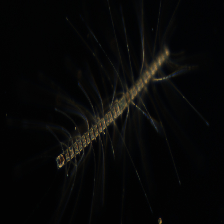

In [ ]:
# resize the chain to 224x224
img_res = img.resize((224,224))

img_res

Notice that the image looks squished. By resizing the images, we lose some of the scale that we human rely on to identify these organisms. In principle, the computer does not care about the scale. 

Think carefully when training and testing NN about how the preprocessing will affect the input data. If you think it is important, the aspect can be preserved. There are also methods to re-insert that information in the network.


## Extracting features from the ResNet

Instead of asking the pretrained model to classify the image, we can use it to pull out features. Here, we will read out the weights associated with the final hidden layer of the network.

In [ ]:
# first, define a copy of the network, but remove the last layer)
feat_extractor = nn.Sequential(*list(resnet18.children())[:-1])

# pump the preprocessed image through the network
feats_var = feat_extractor(img_var)

# get the tensor from the end of the truncated network
feats = feats_var.data

# print the dimensions
feats.shape

torch.Size([1, 512, 1, 1])

This tensor has 512 entries corresponding to the weights on the final layer of the network. To collapse this to a single dimension and use as an array, simply flatten it.

In [ ]:
# convert the torch tensor to np array
feats = np.ndarray.flatten(feats.numpy())

feats.shape

(512,)

We have taken the image, run it throught the ResNet trained on ImageNet, and produced a vector of 512 features. These feature can now be used to train a second stage classifier. Basically, we have reduced all the hand engineered feature extraction to just a few lines of code.

## Running all the data through

Now we need to repeat the process for all the images we want to play with. Our expected output will be the # images by # weights

In [ ]:
# Torch has a bunch of dataloading utilities built in. This custom loader adds to their ImageFolder utility to have it 
# return file paths so we can observe the output.
# It assumes that the images are loaded as "{DATASET_PATH}/{class_name}/{image_id}.ext"
dataset = ImageFolderWithPaths(DATASET_PATH, preprocess)

# We can use the transform to set up a block of image for the GPU to process
loader = torch.utils.data.DataLoader(dataset, batch_size=4)

# This gets a single batch of images
images, labels, paths = next(iter(loader))

# print the shape of the tensors
print("images:", images.shape)
print("labels:", labels.shape)

images: torch.Size([4, 3, 224, 224])
labels: torch.Size([4])


These inputs were transformed the same way as above, but now the first dimension is 4. This means there are 4 images stacked on top of eachother. This is the *batch_size* and dictates how many images are passed to the network at once. 

*paths* is a tuple with the path to each file in it. This will be used to view the images later. 

Now lets see what the output looks like for these 4 images.

In [ ]:
# Make the tensor into a variable
images_var = Variable(images)

# pass the images through the network and retrieve the labels
feats_small = feat_extractor(images_var)

# just pull out the data and convert to a numpy
feats_small = feats_small.data.numpy()

# make it into an array and remove extra dimensions
feats_small = np.asarray(feats_small)[:, :, 0, 0]

# check the dimensions
feats_small.shape

(4, 512)

This is the shape we expect: 4 rows, 512 features corresponding to the weights on each filter. To extract the features from every image requires a for-loop. In we attempted to define a batch that was the entire dataset, the computer would run out of memory. 

In [ ]:
# define the new loader with the bigger batchsize
loader_all = torch.utils.data.DataLoader(dataset, batch_size=128)

# initalize an empty dictonarty to store the features by image path
feat_dict = {}

# put the network on the GPU
feat_extractor = feat_extractor.cuda()

# tell the network not to compute gradients since we aren't training
with torch.no_grad():
    
    # use the tqdm module to monitor the progress of the extractor
    with tqdm_notebook(loader_all, desc="Evaluating") as t:
        
        # iterate over each batch of 128 in the loader
        for inputs, labels, paths in t:
            
            # put the images onto the GPU
            inputs = inputs.cuda()
            
            # extract the features
            feats_temp = feat_extractor(inputs)
            
            # bring output tensor back onto CPU and collapse extra dimensions
            feats_temp = feats_temp.cpu().data.numpy()[:, :, 0, 0]
            
            # put into the dictionary
            temp_dict = {paths[ii]: {'features': feats_temp[ii, :]}
                         for ii in range(len(paths))}
            
            # add the temporary dictionary to the output
            feat_dict.update(temp_dict)

*feat_dict* is organized by the file path of each image. The images have the 512 features associated with them. Again, these features are in many ways akin to those we hand-engineered earlier. But these are defined by a computer trained for generic object classification. 

## Train a RF model

With the ResNet 18 features in hand, we can go ahead and train another Random Forest (RF) using the new features. First, we need to associate a numeric label with each of the images.



In [ ]:
# 80-20 train-test split

# Train model, not sure # of trees

# Run model on test data

## Compare result to hand-engineered features

## Discuss appending hand-engineered features to ResNet features